<a href="https://colab.research.google.com/github/dhanmoti/ml-exercise/blob/smu-fnce685-project/SMU_FNCE685_G2_PD_Prediction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMU FNCE 865 Financial Risk Managment

## Group 2
* Zaw Moe Aung
* Nirbay Bakshi
* Phan Thuy Tien
* Sharmini D/O POONAJAGARAN
* Dhan Moti

# Define the Problem & **Objectives**

## Objective
* **Static PD Model**: Predicts probability of default (PD) at loan origination based on borrower characteristics at application.

* **Dynamic PD Model**: Adjusts PD over time by incorporating loan performance trends and changing borrower behavior.

### Hypothesis
A dynamic PD model provides better predictions by adapting to changing borrower conditions, whereas a static model can only be used at loan origination stage.

### Data source
[Kaggle](https://www.kaggle.com/competitions/loan-default-pred/data?select=loan_test.csv)


### Feature selection
* Domain based
* LASSO
* XGBRegressor

# Install & Import

In [196]:
# Install packages if required
# !pip install -q kaggle
# !pip install xgboost catboost
# !pip install ace_tools
# !pip install ydata_profiling swifter
# !pip install pycaret[full]
# !pip install scikit-learn-intelex
# !pip install fastapi[all] mlflow pyngrok
# !pip install shap

In [197]:
# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [198]:
 # Setting up kaggle
# from google.colab import files

# files.upload()
# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# # Download Kaggle data
# ! kaggle competitions download -c loan-default-pred
# !unzip loan-default-pred.zip

# Load

In [199]:
# Load dataset
df_train_raw = pd.read_csv("/content/loan_train.csv")
df_train = df_train_raw.copy()

# Check Data Types & Convert Columns if Needed


In [200]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       27003 non-null  int64  
 1   member_id                27003 non-null  int64  
 2   loan_amnt                27003 non-null  int64  
 3   funded_amnt              27003 non-null  int64  
 4   funded_amnt_inv          27003 non-null  float64
 5   term                     27003 non-null  object 
 6   int_rate                 27003 non-null  object 
 7   installment              27003 non-null  float64
 8   grade                    27003 non-null  object 
 9   sub_grade                27003 non-null  object 
 10  emp_title                25321 non-null  object 
 11  emp_length               26273 non-null  object 
 12  home_ownership           27003 non-null  object 
 13  annual_inc               27003 non-null  float64
 14  verification_status   

In [201]:
df_train.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,540179,697401,10000,10000,9975.0,36 months,13.23%,338.05,C,C1,...,11943.68,10000.00,1973.61,0.0,0.00,0.0,Sep-12,3536.63,Mar-14,0.0
1,585434,752191,14000,14000,13775.0,36 months,7.88%,437.94,A,A5,...,15470.79,14000.00,1723.48,0.0,0.00,0.0,May-13,2603.31,Jan-16,0.0
2,457736,569298,9475,9475,9475.0,36 months,8.94%,301.04,A,A5,...,10472.09,9475.00,997.09,0.0,0.00,0.0,May-11,5365.49,Aug-15,0.0
3,734349,930860,4000,4000,4000.0,36 months,7.29%,124.04,A,A4,...,4425.26,4000.00,425.26,0.0,0.00,0.0,Jul-13,1336.22,May-15,0.0
4,1050080,1281522,3600,3600,3600.0,36 months,6.62%,110.54,A,A2,...,2321.34,2004.17,306.88,0.0,10.29,0.0,Sep-13,110.54,May-16,0.0


In [202]:
# Drop unnecessary columns
# 'issue_d', 'last_pymnt_d' and 'last_pymnt_amnt' might introduce data leakage because these info will be available only after default
# 'last_credit_pull_d' -> If this column reflects a credit inquiry date made after a significant loan event (e.g., a default or a restructuring), it might leak future information.
# 'recoveries' and 'collection_recovery_fee' -> suspect data leakage after analysing using SHAP where this features standout
# 'int_rate' -> Interest Rate on the loan. suspect data leakage after analysing using SHAP where this features standout
cols_to_drop = [
    'id',
    'member_id',
    'url',
    'desc',
    'title',
    'emp_title',
    'zip_code',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d',
    'issue_d',
    'recoveries',
    'collection_recovery_fee',
    'int_rate'
]
df_train.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [203]:
df_train['revol_util'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 27003 entries, 0 to 27002
Series name: revol_util
Non-Null Count  Dtype 
--------------  ----- 
26968 non-null  object
dtypes: object(1)
memory usage: 211.1+ KB


In [204]:
# Convert interest rate from percentage string to float.
if 'int_rate' in df_train.columns:
    df_train['int_rate'] = df_train['int_rate'].str.rstrip('%').astype(float)
#2.1 Convert revol_util from percentage string to float.
if 'revol_util' in df_train.columns:
    df_train['revol_util'] = df_train['revol_util'].str.rstrip('%').astype(float)

# 3. Convert date columns to datetime objects.
date_columns = {
      'last_pymnt_d': '%b-%y',
      'last_credit_pull_d': '%b-%y',
      'earliest_cr_line': '%b-%y'
}
for col, date_format in date_columns.items():
    if col in df_train.columns:
        df_train[col] = pd.to_datetime(df_train[col], format=date_format)


In [205]:
# Convert date to ordinal numerical data
datetime_cols = df_train.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    df_train[col] = df_train[col].apply(lambda x: x.toordinal() if pd.notnull(x) else None)


# 4. Label encode specified ordinal columns.
ordinal_columns = ['term', 'grade', 'sub_grade', 'emp_length']
label_encoders = {}
for col in ordinal_columns:
    if col in df_train.columns:
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col])
        label_encoders[col] = le

# 5. Identify any remaining categorical columns and apply one-hot encoding.
categorical_cols = df_train.select_dtypes(include=['object']).columns
print("Categorical Columns for one-hot encoding:", list(categorical_cols))
df_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

Categorical Columns for one-hot encoding: ['home_ownership', 'verification_status', 'purpose', 'addr_state']


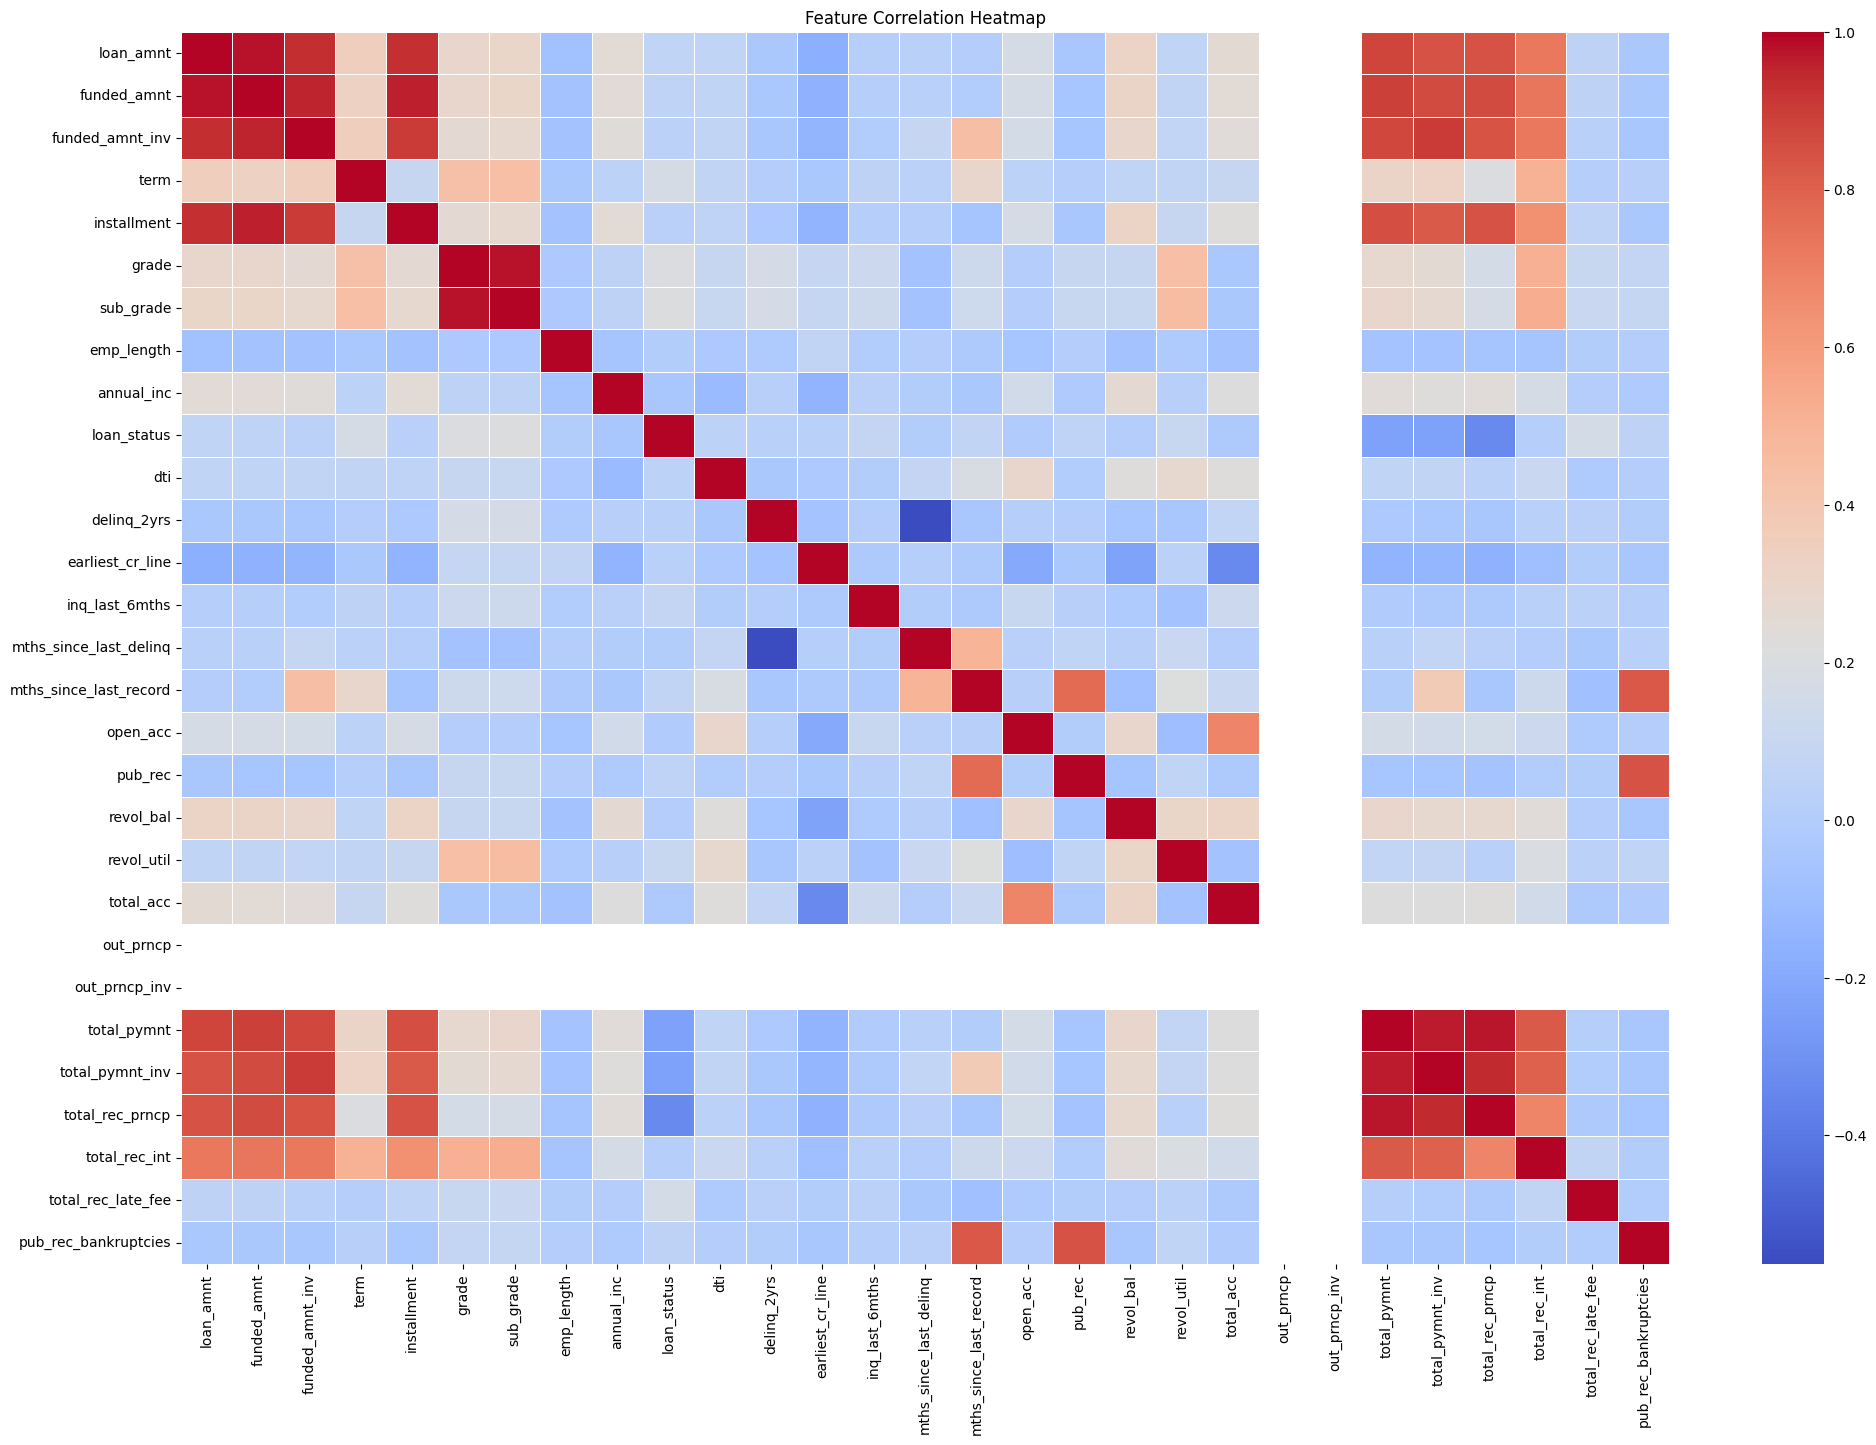

In [206]:
# Show correlation matrix

annot=False
figsize=(24, 16)
cmap="coolwarm"
linewidths=0.5
columns_subset=None

if columns_subset is not None:
    data = df_encoded[columns_subset]
else:
    data = df_encoded.select_dtypes(include=[np.number])

# Compute the correlation matrix.
corr_matrix = data.corr()

# Create the heatmap.
plt.figure(figsize=figsize)
sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, linewidths=linewidths)
plt.title("Feature Correlation Heatmap")
plt.show()

In [207]:
# [!Warning] Too slow
# Drop drop_highly_correlated_features
# df_train_clean_drop_hicorr, dropped = drop_highly_correlated_features(df_train_clean, threshold=0.75)
threshold = 0.75

# Create a mask for the upper triangle (excluding the diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop: any column with a correlation value greater than the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop these columns from the DataFrame
df_encoded = df_encoded.drop(columns=to_drop)

# Handle missing data

In [208]:
# Calculate percentage of missing values for each column
missing_percent = df_encoded.isnull().mean() * 100

# Create a DataFrame to display the results neatly
missing_table = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing Percentage': missing_percent.values
})

# Sort the table by missing percentage (highest first) and display it
missing_table.sort_values(by='Missing Percentage', ascending=False, inplace=True)
print(missing_table)

                        Column  Missing Percentage
11      mths_since_last_record           92.823020
10      mths_since_last_delinq           64.418768
14                  revol_util            0.129615
0                    loan_amnt            0.000000
56               addr_state_MA            0.000000
..                         ...                 ...
29               purpose_house            0.000000
28    purpose_home_improvement            0.000000
27         purpose_educational            0.000000
26  purpose_debt_consolidation            0.000000
86               addr_state_WY            0.000000

[87 rows x 2 columns]


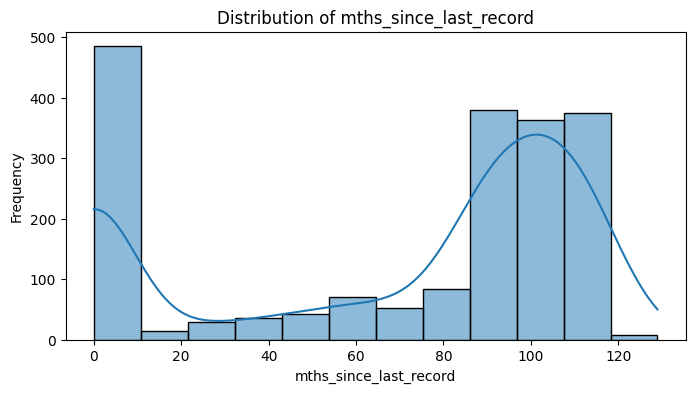

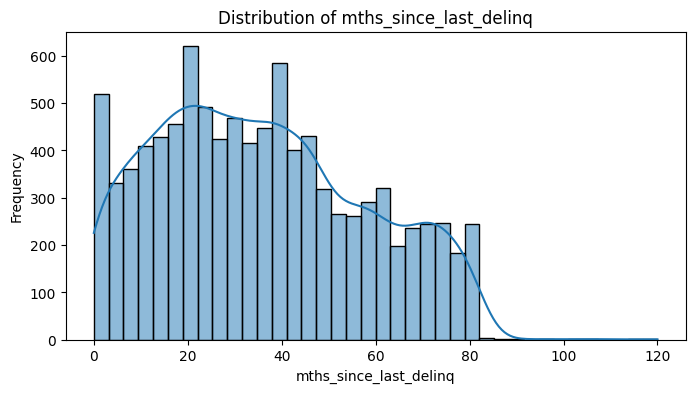

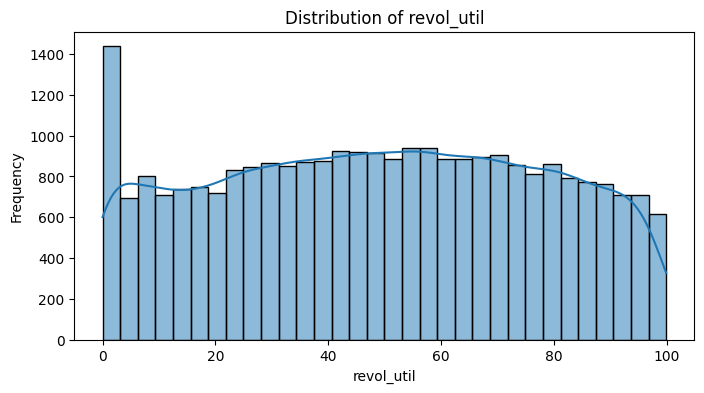

In [209]:
# Visualise numeric columns
numeric_cols = ['mths_since_last_record', 'mths_since_last_delinq', 'revol_util']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_encoded[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [210]:
# Handle missing values
df_encoded['revol_util'].fillna(df_encoded['revol_util'].mean(), inplace=True)

# Handle missing values with a default number
df_encoded['mths_since_last_record'].fillna(-1, inplace=True)
df_encoded['mths_since_last_delinq'].fillna(-1, inplace=True)

In [211]:
missing_counts = df_encoded.isnull().sum()
print(missing_counts.sum())

0


# Split Data

In [212]:
# Sepearte Features and target
X = df_encoded.drop(columns=['loan_status'])
y = df_encoded['loan_status']

In [213]:
# Split
from sklearn.model_selection import train_test_split

# # First, split off the test set (20% of the data)
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Next, split the remaining data into training and validation sets.
# # Since X_train_val is 80% of the data, using test_size=0.25 here will give you:
# # 0.25 * 80% = 20% of the total data for validation, and the rest (60%) for training.
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# # Split data %:
# # - X_train, y_train: 60% of the data
# # - X_val, y_val: 20% of the data
# # - X_test, y_test: 20% of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Balance data using SMOTE

In [214]:
def visualiseImbalanceData(y):
  # Visualize class imbalance in the target variable
  plt.figure(figsize=(8, 6))
  sns.countplot(x=y)
  plt.title("Class Distribution Before SMOTE")
  plt.xlabel("Class")
  plt.ylabel("Frequency")
  plt.show()

  # Additionally, print out the counts
  print("Class distribution:")
  print(y.value_counts())

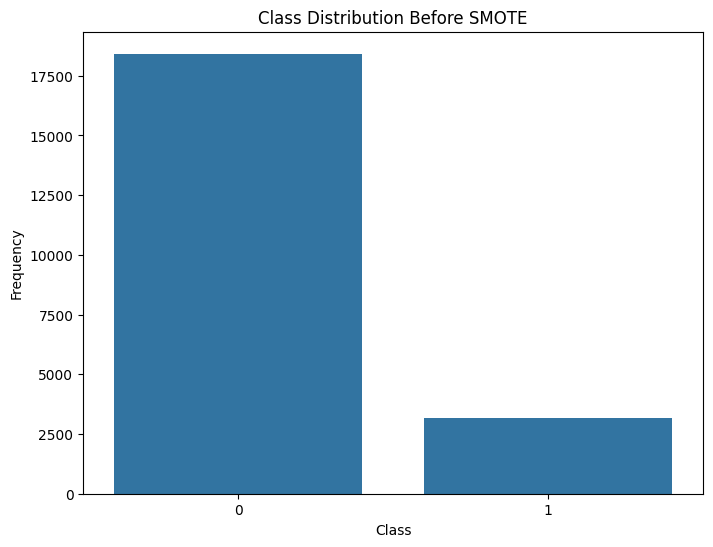

Class distribution:
loan_status
0    18420
1     3182
Name: count, dtype: int64


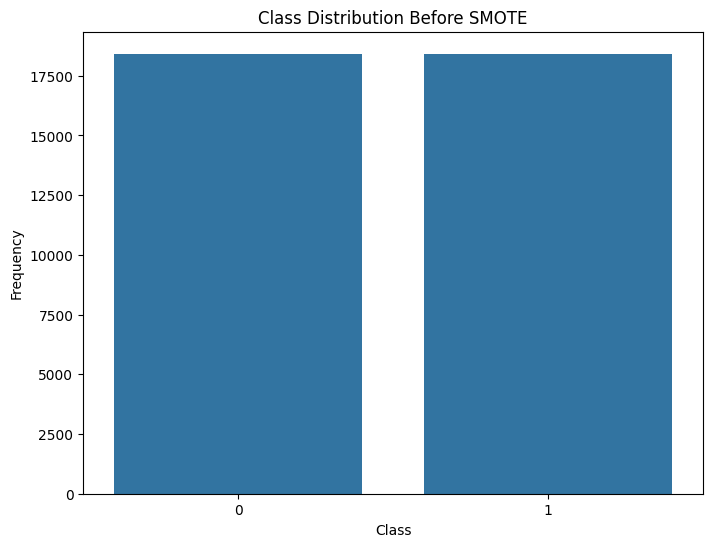

Class distribution:
loan_status
0    18420
1    18420
Name: count, dtype: int64


In [215]:
visualiseImbalanceData(y_train)

# # Now apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

visualiseImbalanceData(y_resampled)

# Standardize

In [216]:
# Standardize Features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Identify numeric columns in your DataFrame
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a ColumnTransformer that applies StandardScaler to numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'  # Keeps the other columns unchanged
)

# Fit the preprocessor on your training data and transform both train and test sets
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Apply LASSO

In [217]:
# Apply Lasso with cross-validation to find the optimal regularization parameter

# Handle class imbalance using SMOTE [analyse whether data is imblance first]
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Suppose X contains your feature set and y your target variable.
# Create an imputer instance; here we use the mean to fill missing values.
imputer = SimpleImputer(strategy='mean')

# Fit and transform the feature set.
X_imputed = imputer.fit_transform(X)

alphas = np.logspace(-5, 0, 200)  # Experiment with a wider range of alphas
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Identify features with non-zero coefficients
selected_features = X_train.columns[lasso_cv.coef_ != 0]
print("Selected features:", list(selected_features))

# Evaluate performance on the test set
# y_pred_lasso = lasso_cv.predict(X_test_scaled)
# mse = mean_squared_error(X_test_scaled, y_pred_lasso)
# print("Mean Squared Error:", mse)
# [todo] use accuray, precision, recall matrix to measure perfomance. this step is for lr model only

# [todo] althernative approach - recursive elimination/step wise/[skip]

Selected features: ['loan_amnt', 'term', 'grade', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_record', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'purpose_credit_card', 'purpose_major_purchase', 'purpose_medical', 'purpose_other', 'purpose_small_business', 'purpose_wedding', 'addr_state_CA', 'addr_state_CT', 'addr_state_FL', 'addr_state_NJ', 'addr_state_NV', 'addr_state_NY', 'addr_state_TX']


# Based Model - Before Feature engineering

In [218]:
# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Define the thresholds to highlight
    desired_thresholds = [0.3, 0.5, 0.7]

    # Function to find the closest threshold
    def find_closest_threshold(thresholds, desired_thresh):
        idx = np.argmin(np.abs(thresholds - desired_thresh))
        return idx

    # Highlight specific threshold points
    for thresh in desired_thresholds:
        idx = find_closest_threshold(thresholds, thresh)
        plt.scatter(fpr[idx], tpr[idx], label=f'Threshold ≈ {thresholds[idx]:.2f}', marker='o')

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [219]:
# Select features
X_train_lr = X_train[selected_features]  # Features
X_test_lr = X_test[selected_features]  # Features
y_train_lr = y_train.copy()
y_test_lr = y_test.copy()


LogisticRegression Performance:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79      4606
           1       0.26      0.62      0.36       795

    accuracy                           0.68      5401
   macro avg       0.58      0.65      0.57      5401
weighted avg       0.82      0.68      0.72      5401



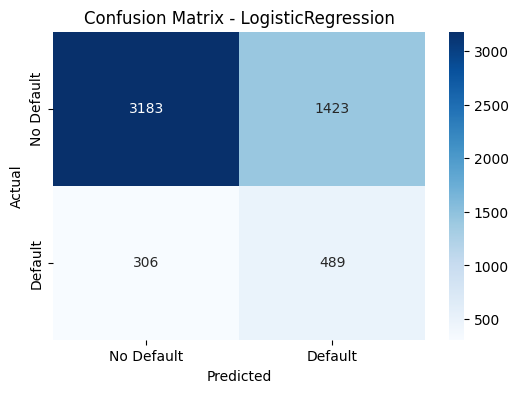

Model Performance Metrics:
                 Score
Accuracy        0.6799
Precision       0.2558
Recall          0.6151
F1-score        0.3613
AUC             0.7189
Train Accuracy  0.6761
Test Accuracy   0.6799
Train AUC       0.7155
Test AUC        0.7189


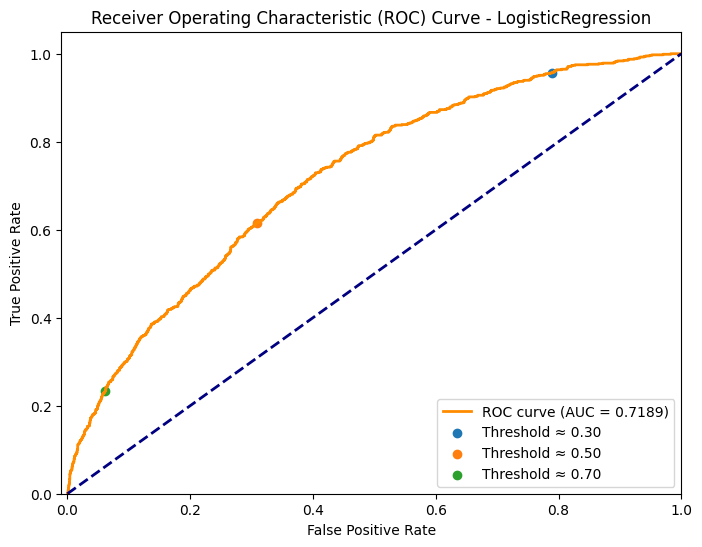

In [220]:
# Define models
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
model.fit(X_train_lr, y_train_lr)

# Predictions on test data
y_pred = model.predict(X_test_lr)

# Use predict_proba if available, otherwise decision_function
if hasattr(model, "predict_proba"):
    y_pred_proba = model.predict_proba(X_test_lr)[:, 1]
    train_pred_proba = model.predict_proba(X_train_lr)[:, 1]
else:
    y_pred_proba = model.decision_function(X_test_lr)
    train_pred_proba = model.decision_function(X_train_lr)

result = {
        "Accuracy": accuracy_score(y_test_lr, y_pred),
        "Precision": precision_score(y_test_lr, y_pred),
        "Recall": recall_score(y_test_lr, y_pred),
        "F1-score": f1_score(y_test_lr, y_pred),
        "AUC": roc_auc_score(y_test_lr, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train_lr, model.predict(X_train_lr)),
        "Test Accuracy": accuracy_score(y_test_lr, y_pred),
        "Train AUC": roc_auc_score(y_train_lr, train_pred_proba),
        "Test AUC": roc_auc_score(y_test_lr, y_pred_proba)
    }

# Print classification report for each model
print(f"\n{'LogisticRegression'} Performance:")
print(classification_report(y_test_lr, y_pred))

# Plot confusion matrix for each model
cm = confusion_matrix(y_test_lr, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {'LogisticRegression'}")
plt.show()

# Convert the dictionary into a DataFrame
result_df = pd.DataFrame(result, index=[0]).T  # Transpose to have metrics as rows
result_df.columns = ['Score']
result_df = result_df.round(4)  # Optional: round the values for clarity

print("Model Performance Metrics:")
print(result_df)

plot_roc_curve(y_test, y_pred_proba, "LogisticRegression")

In [221]:
import joblib
joblib.dump(model, 'based_model.pkl')

['based_model.pkl']

# SHAP Analysis on XGBRegressor before feature engineering

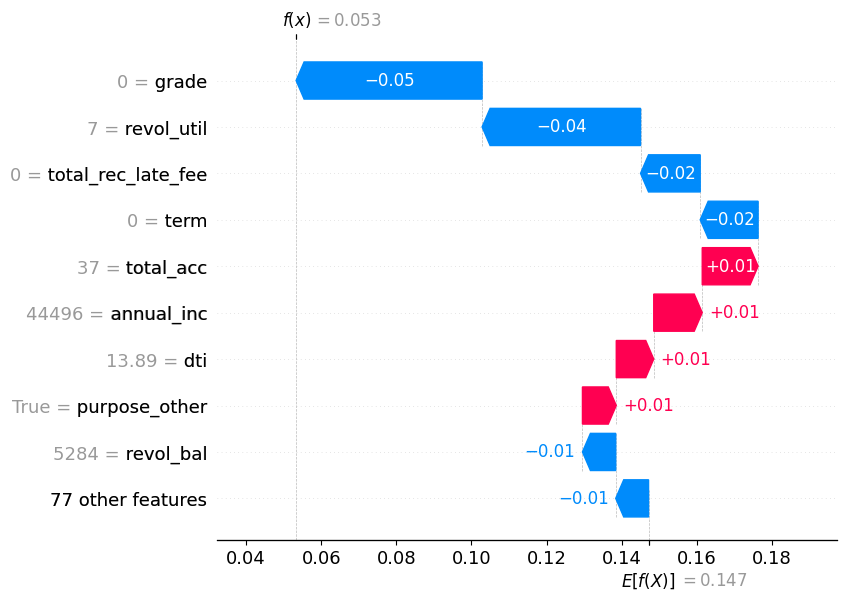

In [222]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
shap.initjs()

# Creating an XGBRegressor model
model_xgd = xgb.XGBRegressor()
model_xgd.fit(X_train, y_train)

# SHAP Explainer
explainer = shap.Explainer(model_xgd)
shap_values = explainer(X_test)

# Waterfall plot for the first observation
shap.waterfall_plot(shap_values[0])
# eg. this shows direction > terms_60 has neg rel with target. assuming other features r constant

In [223]:
import joblib
joblib.dump(model_xgd, 'xgd_before_fe_model.pkl')

['xgd_before_fe_model.pkl']

# Feature engineering for dynamic model

In [237]:
# clean data before
df_fe = df_train_raw.copy()

In [238]:
# 1. Drop unnecessary columns (ignore if any are missing).
# 'mths_since_last_record', 'mths_since_last_delinq' dropped due to high missing values > 60%
# 'addr_state' dropped due to high number of cols after one-hot encoding
# 'issue_d', 'last_pymnt_d' and 'last_pymnt_amnt' might introduce data leakage because these info will be available only after default
# 'last_credit_pull_d' -> If this column reflects a credit inquiry date made after a significant loan event (e.g., a default or a restructuring), it might leak future information.
# 'recoveries' and 'collection_recovery_fee' -> suspect data leakage after analysing using SHAP where this features standout
# 'int_rate' -> Interest Rate on the loan. suspect data leakage after analysing using SHAP where this features standout
cols_to_drop = [
    'id',
    # 'member_id', # we will keep this member id for feature engineering
    'url',
    'desc',
    'title',
    'emp_title',
    'zip_code',
    'addr_state',
    'mths_since_last_record',
    'mths_since_last_delinq',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d',
    'issue_d',
    'recoveries',
    'collection_recovery_fee',
    'int_rate',

]
df_fe.drop(columns=cols_to_drop, errors='ignore', inplace=True)

# 2. Convert interest rate from percentage string to float.
if 'int_rate' in df_fe.columns:
    df_fe['int_rate'] = df_fe['int_rate'].str.rstrip('%').astype(float)
#2.1 Convert revol_util from percentage string to float.
if 'revol_util' in df_fe.columns:
    df_fe['revol_util'] = df_fe['revol_util'].str.rstrip('%').astype(float)

# 3. Convert date columns to datetime objects.
date_columns = {
      #'issue_d': '%b-%y',
     # 'last_pymnt_d': '%b-%y',
      'last_credit_pull_d': '%b-%y',
      'earliest_cr_line': '%b-%y'
}
for col, date_format in date_columns.items():
    if col in df_fe.columns:
        df_fe[col] = pd.to_datetime(df_fe[col], format=date_format)

## 1. Time-based feature

### ✅ Loan Age (Months)
**Definition**: The number of months since the borrower’s earliest recorded credit line.

#### Why it matters?
* A longer credit history typically indicates a more experienced borrower, reducing default risk.
* New borrowers tend to have higher risk.
* Formula:Loan Age (Months)=(2025−Earliest Credit Line Year)×12+(1−Month)*Loan Age (Months)=(2025−Earliest Credit Line Year)×12+(1−Month)

* **Application in Model**:
Used to differentiate between new vs. old borrowers.
Helps in time-series-based default predictions.



In [239]:
# --- 1. Time-Based Features ---

# Convert earliest credit line to datetime and extract year
df_fe['earliest_cr_line'] = pd.to_datetime(df_fe['earliest_cr_line'], format='%b-%y', errors='coerce')

# Compute Loan Age (Months) based on the assumption that the current year is 2025
df_fe['loan_age_months'] = (2025 - df_fe['earliest_cr_line'].dt.year) * 12

# Compute rolling default rate by year
df_fe['yearly_default_rate'] = df_fe.groupby(df_fe['earliest_cr_line'].dt.year)['loan_status'].transform('mean')

In [240]:
# --- 2. Credit Behavior Features ---

# Credit Utilization Ratio
df_fe['credit_utilization_ratio'] = df_fe['revol_bal'] / (df_fe['loan_amnt'] + 1)  # Avoid division by zero

# Rolling Average of Debt-to-Income Ratio (DTI)
df_fe['rolling_dti'] = df_fe['dti'].rolling(window=3, min_periods=1).mean()

In [241]:
# --- 3. Aggregated Default History Features ---

# Identify purpose columns
purpose_columns = [col for col in df_fe.columns if col.startswith('purpose_')]

# Row-level calculations:
# Compute numerator: each purpose indicator multiplied by loan_status (assuming loan_status is 1 for default, 0 otherwise)
df_fe['row_numerator'] = df_fe[purpose_columns].mul(df_fe['loan_status'], axis=0).sum(axis=1)
# Compute denominator: sum of purpose indicators (replace 0 with 1 later to avoid division by zero)
df_fe['row_denominator'] = df_fe[purpose_columns].sum(axis=1)

# Compute the row-level default rate (using .replace to avoid dividing by 0)
df_fe['purpose_default_rate'] = df_fe['row_numerator'] / df_fe['row_denominator'].replace(0, 1)

# Now, compute the default rate for each member.
# Aggregate numerator and denominator by member_id, then take their ratio.
member_default_rate = df_fe.groupby('member_id').apply(
    lambda group: group['row_numerator'].sum() / group['row_denominator'].sum() if group['row_denominator'].sum() != 0 else 0
).reset_index(name='member_default_rate')

# Drop these columns from the DataFrame
df_fe_cleaned = df_fe.drop(columns=['member_id'])

In [242]:
# --- 4. Risk Indicator Transformations ---

# Log transformation for skewed variables. same as standardsclar
skewed_cols = ['loan_amnt', 'annual_inc', 'dti']
for col in skewed_cols:
    df_fe_cleaned[col] = np.log1p(df_fe_cleaned[col])  # log1p to handle zero values

In [243]:
# Standardization for Interest Rate
# df_fe['int_rate'] = (df_fe['int_rate'] - df_fe['int_rate'].mean()) / df_fe['int_rate'].std()

# Drop original date column (earliest_cr_line) after feature extraction
df_fe_cleaned.drop(columns=['earliest_cr_line'], inplace=True)


# Handle mising data

In [244]:
# Calculate percentage of missing values for each column
missing_percent = df_fe_cleaned.isnull().mean() * 100

# Create a DataFrame to display the results neatly
missing_table = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing Percentage': missing_percent.values
})

# Sort the table by missing percentage (highest first) and display it
missing_table.sort_values(by='Missing Percentage', ascending=False, inplace=True)
print(missing_table)

                      Column  Missing Percentage
7                 emp_length            2.703403
28      pub_rec_bankruptcies            1.862756
19                revol_util            0.129615
27        total_rec_late_fee            0.000000
21                 out_prncp            0.000000
22             out_prncp_inv            0.000000
23               total_pymnt            0.000000
24           total_pymnt_inv            0.000000
25           total_rec_prncp            0.000000
26             total_rec_int            0.000000
0                  loan_amnt            0.000000
29           loan_age_months            0.000000
30       yearly_default_rate            0.000000
31  credit_utilization_ratio            0.000000
32               rolling_dti            0.000000
33             row_numerator            0.000000
34           row_denominator            0.000000
20                 total_acc            0.000000
18                 revol_bal            0.000000
1                fun

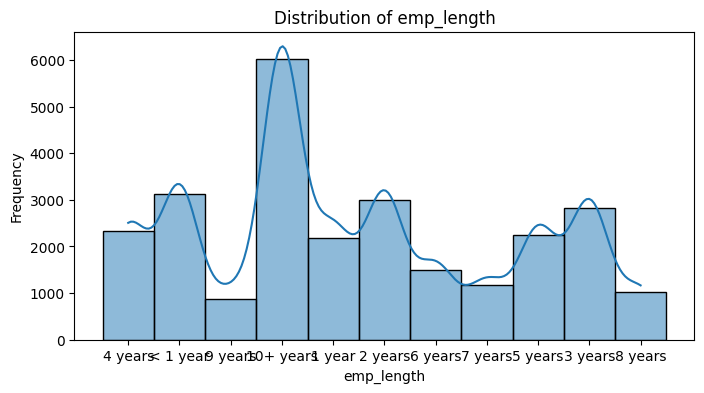

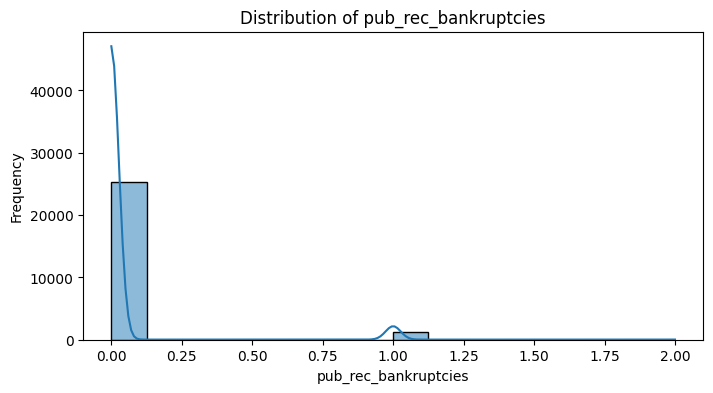

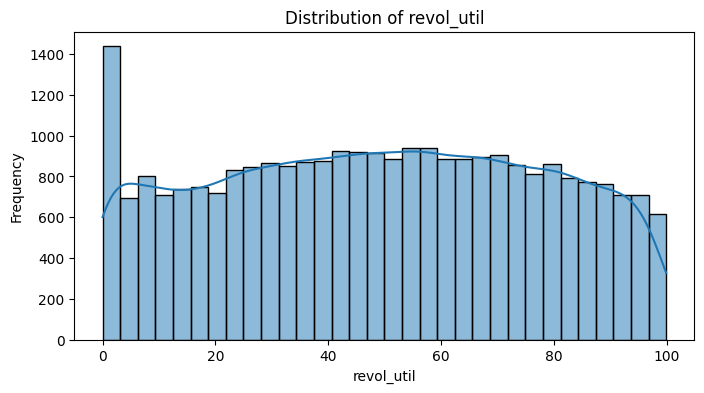

In [245]:
# Visualise numeric columns
numeric_cols = ['emp_length', 'pub_rec_bankruptcies', 'revol_util']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_fe_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [246]:
# Handle missing values. Drop if it is not normal distribution
df_fe_cleaned['pub_rec_bankruptcies'].fillna(df_fe_cleaned[col].mode(), inplace=True)
df_fe_cleaned['emp_length'].fillna(df_fe_cleaned[col].median(), inplace=True)
df_fe_cleaned['revol_util'].fillna(df_fe_cleaned[col].mean(), inplace=True)

# Handle missing values with a default number
df_encoded['mths_since_last_record'].fillna(-1, inplace=True)
df_encoded['mths_since_last_delinq'].fillna(-1, inplace=True)

In [247]:
# 3. Convert date columns to datetime objects.
date_columns = {
      'last_credit_pull_d': '%b-%y',
      'earliest_cr_line': '%b-%y'
}
for col, date_format in date_columns.items():
    if col in df_fe_cleaned.columns:
        df_fe_cleaned[col] = pd.to_datetime(df_fe_cleaned[col], format=date_format)

# 3.1 Convert date to ordinal numerical data
datetime_cols = df_fe_cleaned.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    df_fe_cleaned[col] = df_fe_cleaned[col].apply(lambda x: x.toordinal() if pd.notnull(x) else None)

In [248]:
df_fe_cleaned['emp_length']

,emp_length
0,4 years
1,< 1 year
2,9 years
3,10+ years
4,1 year
...,...
26998,< 1 year
26999,49.1
27000,8 years
27001,2 years


In [249]:
# 4. Label encode specified ordinal columns.
# Define the mapping from text to numeric values
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'n/a': np.nan
}

# Convert emp_length to a numeric column using the map
df_fe_cleaned['emp_length_numeric'] = df_fe_cleaned['emp_length'].map(emp_length_map)

# 5. Identify any remaining categorical columns and apply one-hot encoding.
# require for logistic regression only
categorical_cols = df_fe_cleaned.select_dtypes(include=['object']).columns
print("Categorical Columns for one-hot encoding:", list(categorical_cols))
df_fe_cleaned = pd.get_dummies(df_fe_cleaned, columns=categorical_cols, drop_first=True)

Categorical Columns for one-hot encoding: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']


In [250]:
df_fe_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Columns: 101 entries, loan_amnt to purpose_wedding
dtypes: bool(71), float64(21), int32(1), int64(8)
memory usage: 7.9 MB


In [251]:
# Handle missing values.
df_fe_cleaned.dropna(inplace=True)

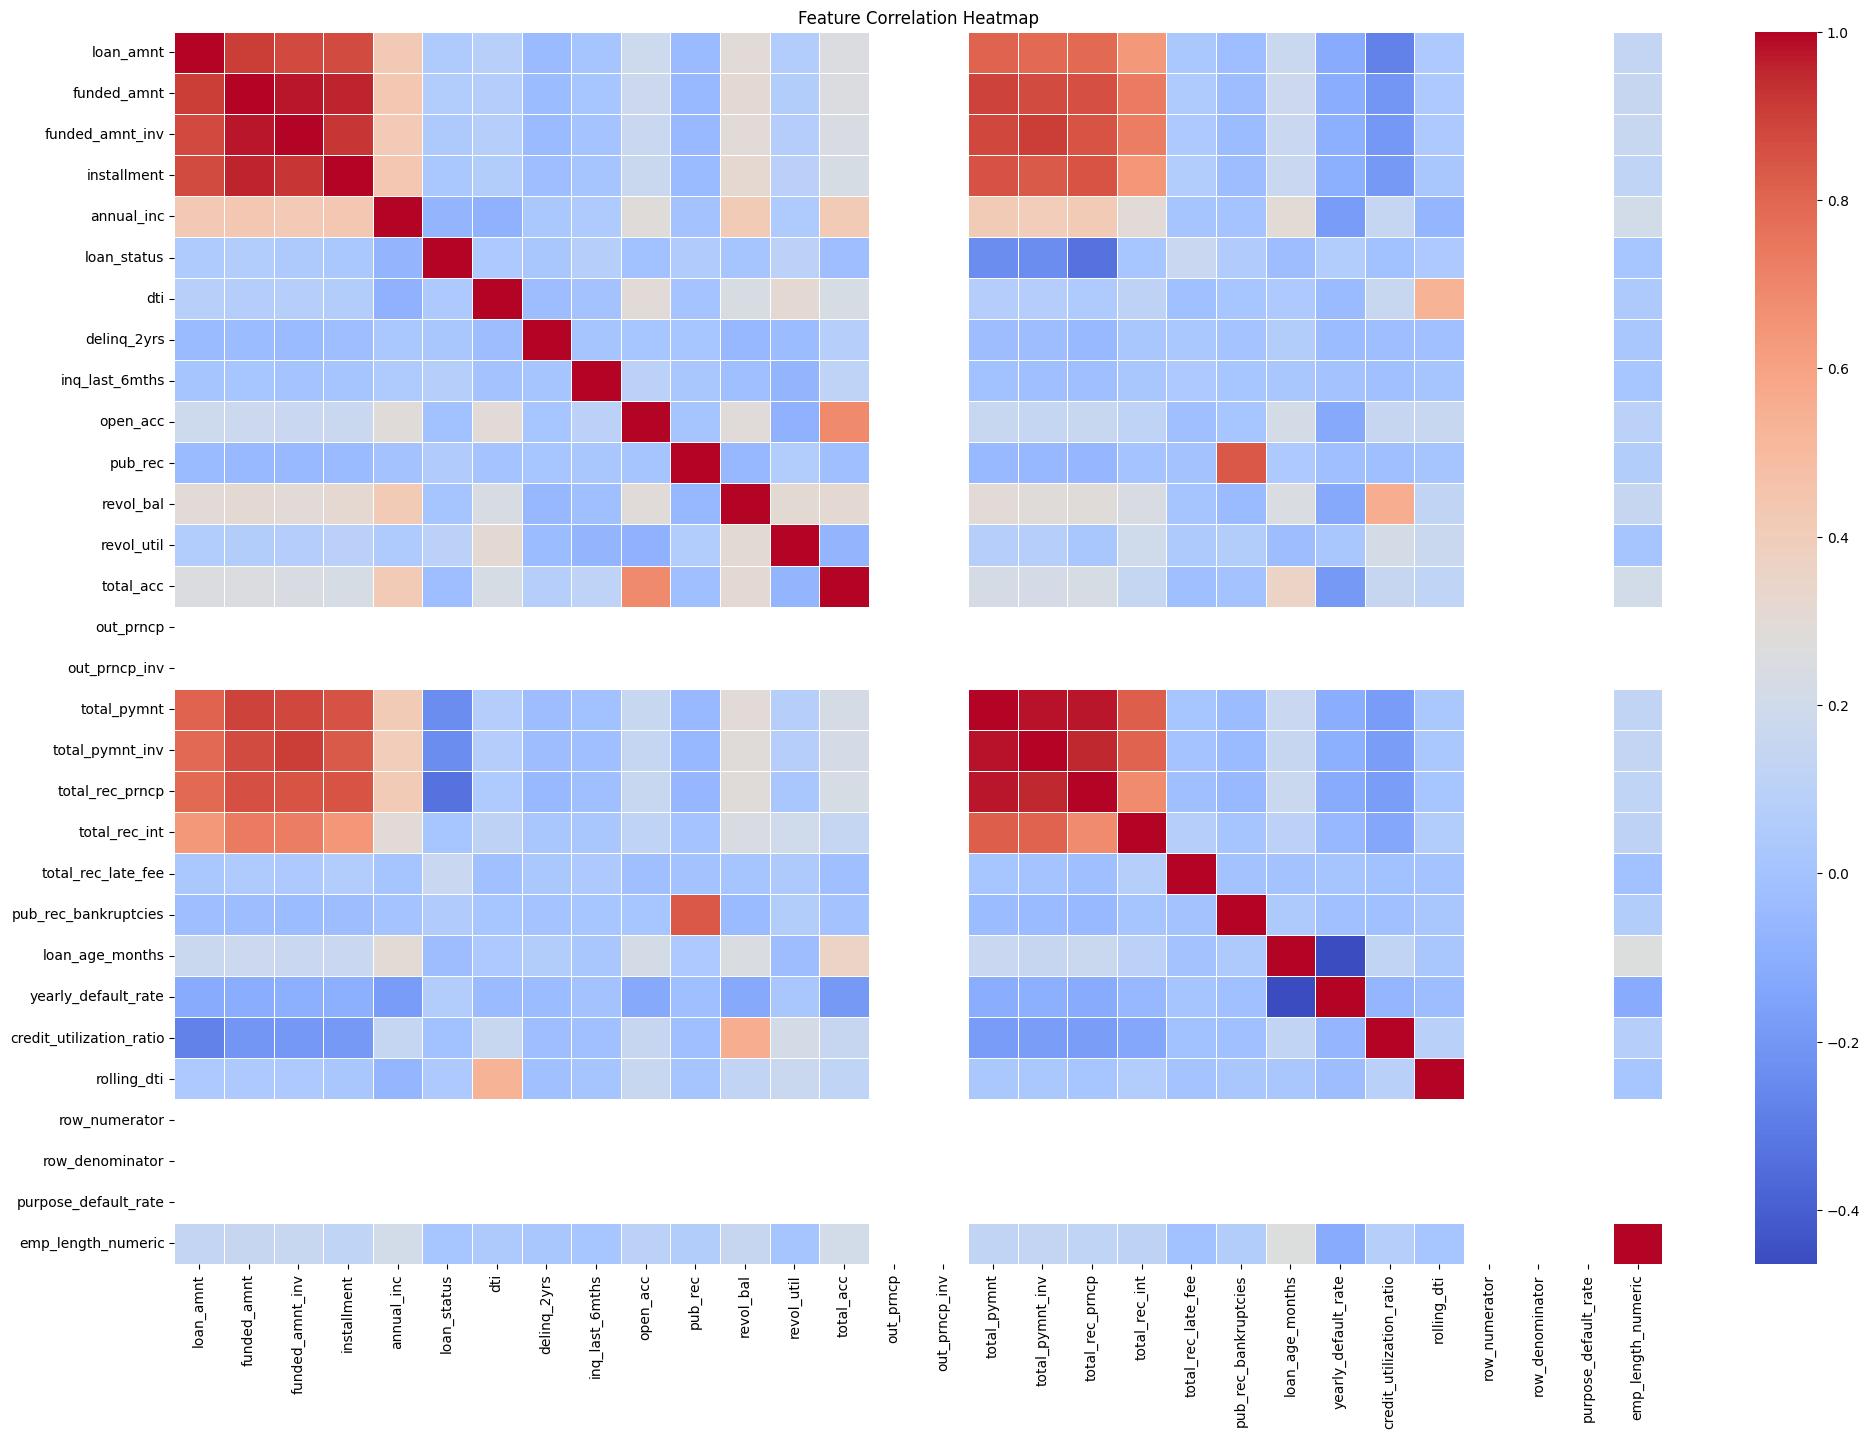

In [252]:
# Show correlation matrix

annot=False
figsize=(24, 16)
cmap="coolwarm"
linewidths=0.5
columns_subset=None

if columns_subset is not None:
    data = df_fe_cleaned[columns_subset]
else:
    data = df_fe_cleaned.select_dtypes(include=[np.number])

# Compute the correlation matrix.
corr_matrix = data.corr()

# Create the heatmap.
plt.figure(figsize=figsize)
sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, linewidths=linewidths)
plt.title("Feature Correlation Heatmap")
plt.show()

In [253]:
# [!Warning] Too slow
# Drop drop_highly_correlated_features
# df_train_clean_drop_hicorr, dropped = drop_highly_correlated_features(df_train_clean, threshold=0.75)
threshold = 0.75

# Create a mask for the upper triangle (excluding the diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop: any column with a correlation value greater than the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop these columns from the DataFrame
df_fe_cleaned = df_fe_cleaned.drop(columns=to_drop)

In [254]:
# Fixed feature naming standard errors such as str containing [, ] < etc
import re

# Remove disallowed characters and replace spaces with underscores
df_fe_cleaned.columns = [
    re.sub(r'[\[\]<>]', '', col).strip().replace(" ", "_")
    for col in df_fe_cleaned.columns
]

In [255]:
df_fe_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25770 entries, 0 to 27002
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            25770 non-null  float64
 1   annual_inc                           25770 non-null  float64
 2   loan_status                          25770 non-null  int64  
 3   dti                                  25770 non-null  float64
 4   delinq_2yrs                          25770 non-null  int64  
 5   inq_last_6mths                       25770 non-null  int64  
 6   open_acc                             25770 non-null  int64  
 7   pub_rec                              25770 non-null  int64  
 8   revol_bal                            25770 non-null  int64  
 9   revol_util                           25770 non-null  float64
 10  total_acc                            25770 non-null  int64  
 11  out_prncp                        

In [256]:
# Separate features and target
X_lasso = df_fe_cleaned.drop(columns=['loan_status'])
y_lasso = df_fe_cleaned['loan_status']
random_state=42

# Split the dataset into training and testing sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso,
                                                            test_size=0.2,
                                                            random_state=random_state)

# Standardize Features
scaler = StandardScaler()
X_train_lasso_scaled = scaler.fit_transform(X_train_lasso)
X_test_lasso_scaled = scaler.transform(X_test_lasso)


# Apply Lasso with cross-validation to find the optimal regularization parameter
alphas = np.logspace(-5, 0, 200)  # Experiment with a wider range of alphas
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=random_state)
lasso_cv.fit(X_train_lasso_scaled, y_train_lasso)

# Identify features with non-zero coefficients
selected_features = X_lasso.columns[lasso_cv.coef_ != 0]
print("Selected features:", list(selected_features))

# # Evaluate performance on the test set
# y_pred_lasso = lasso_cv.predict(X_test_lasso_scaled)
# mse = mean_squared_error(y_test_lasso, y_pred_lasso)
# print("Mean Squared Error:", mse)

Selected features: ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_rec_late_fee', 'yearly_default_rate', 'credit_utilization_ratio', 'rolling_dti', 'emp_length_numeric', 'term__60_months', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'emp_length_10+_years', 'emp_length_4_years', 'emp_length_6_years', 'emp_length_7_years', 'emp_length__1_year', 'verification_status_Verified', 'purpose_credit_card', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical', 'purpose_other', 'purpose_renewa

In [257]:
# Feature selection
X = df_fe_cleaned[selected_features]  # Features
y = (df_fe_cleaned['loan_status'] > 0.5).astype(int)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25770 entries, 0 to 27002
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_amnt                     25770 non-null  float64
 1   annual_inc                    25770 non-null  float64
 2   dti                           25770 non-null  float64
 3   delinq_2yrs                   25770 non-null  int64  
 4   inq_last_6mths                25770 non-null  int64  
 5   open_acc                      25770 non-null  int64  
 6   pub_rec                       25770 non-null  int64  
 7   revol_bal                     25770 non-null  int64  
 8   revol_util                    25770 non-null  float64
 9   total_rec_late_fee            25770 non-null  float64
 10  yearly_default_rate           25770 non-null  float64
 11  credit_utilization_ratio      25770 non-null  float64
 12  rolling_dti                   25770 non-null  float64
 13  emp_le

# Split data

In [258]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance data using SMOTE

In [259]:
# Handle class imbalance using SMOTE [analyse whether data is imblance first]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# StandardScaler

In [260]:
# Create a scaled version for models that require it (i.e. Logistic Regression)
scaler = StandardScaler()
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

numeric_columns = X_test.select_dtypes(include=['int64', 'float64']).columns
X_test[numeric_columns] = scaler.fit_transform(X_test[numeric_columns])

In [261]:
# Check for columns with [, ], or < in their names
invalid_chars = ['[', ']', '<']
invalid_cols = [col for col in X_train.columns if any(char in col for char in invalid_chars)]
print(f"Columns with invalid characters: {invalid_cols}")

# Replace invalid characters with underscores or other valid characters
for col in invalid_cols:
    new_col = col.replace('[', '_').replace(']', '_').replace('<', '_')
    X_train.rename(columns={col: new_col}, inplace=True)
    X_test.rename(columns={col: new_col}, inplace=True)  # Ensure X_test has the same changes

Columns with invalid characters: []


# Logistic Rregression model after feature engineering


LogisticRegression Performance:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      4408
           1       0.27      0.66      0.38       746

    accuracy                           0.69      5154
   macro avg       0.59      0.67      0.59      5154
weighted avg       0.83      0.69      0.73      5154



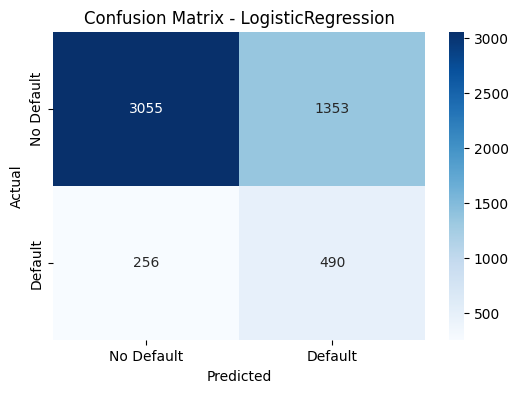

Model Performance Metrics:
                 Score
Accuracy        0.6878
Precision       0.2659
Recall          0.6568
F1-score        0.3785
AUC             0.7404
Train Accuracy  0.6859
Test Accuracy   0.6878
Train AUC       0.7366
Test AUC        0.7404


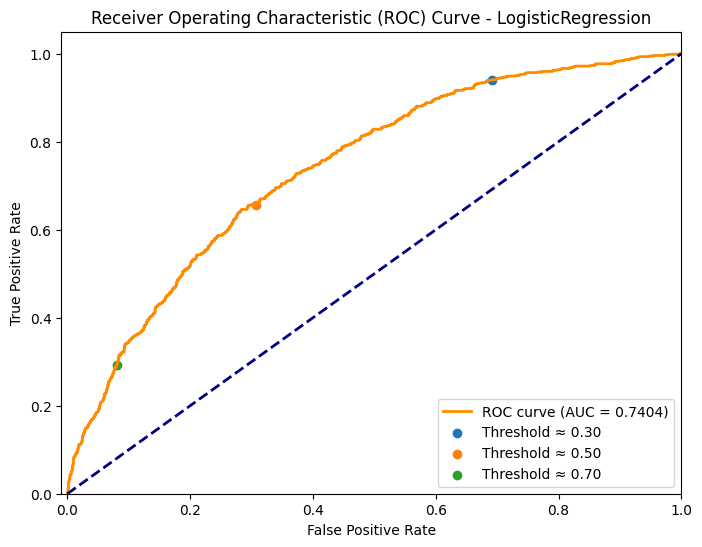

In [262]:
# Define models
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Predictions on test data
y_pred = model.predict(X_test)

# Use predict_proba if available, otherwise decision_function
if hasattr(model, "predict_proba"):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    train_pred_proba = model.predict_proba(X_train)[:, 1]
else:
    y_pred_proba = model.decision_function(X_test)
    train_pred_proba = model.decision_function(X_train)

result = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Train AUC": roc_auc_score(y_train, train_pred_proba),
        "Test AUC": roc_auc_score(y_test, y_pred_proba)
    }

# Print classification report for each model
print(f"\n{'LogisticRegression'} Performance:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix for each model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {'LogisticRegression'}")
plt.show()

# Convert the dictionary into a DataFrame
result_df = pd.DataFrame(result, index=[0]).T  # Transpose to have metrics as rows
result_df.columns = ['Score']
result_df = result_df.round(4)  # Optional: round the values for clarity

print("Model Performance Metrics:")
print(result_df)

plot_roc_curve(y_test, y_pred_proba, "LogisticRegression")

In [263]:
import joblib
joblib.dump(model, 'lr_fe_model.pkl')

['lr_fe_model.pkl']

# SHAP Analysis on XGBRegressor after feature engineering

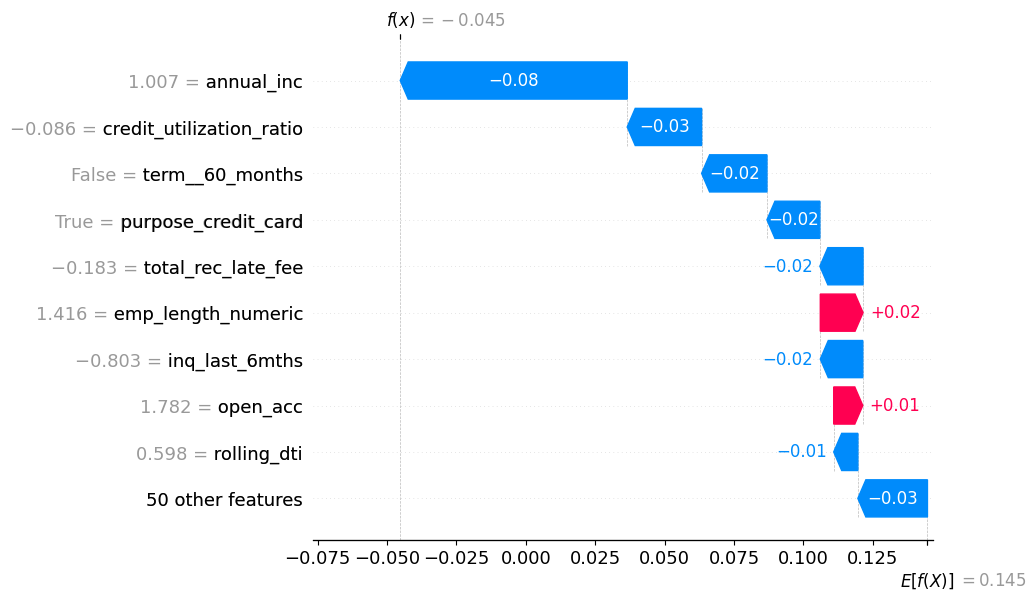

In [264]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
shap.initjs()

# Creating an XGBRegressor model
model_xgb_fe = xgb.XGBRegressor()
model_xgb_fe.fit(X_train, y_train)

# SHAP Explainer
explainer = shap.Explainer(model_xgb_fe)
shap_values = explainer(X_test)

# Waterfall plot for the first observation
shap.waterfall_plot(shap_values[0])
# eg. this shows direction > terms_60 has neg rel with target. assuming other features r constant

In [265]:
model_xgb_fe.feature_importances_

array([0.01278626, 0.01579017, 0.01560855, 0.0114403 , 0.01582489,
       0.01498551, 0.01903562, 0.01601987, 0.01823269, 0.09245135,
       0.01507509, 0.01638409, 0.01505036, 0.0172757 , 0.06119079,
       0.01955437, 0.02671939, 0.02532694, 0.02004562, 0.0234724 ,
       0.00773021, 0.01442826, 0.01410711, 0.01044496, 0.00898418,
       0.01380984, 0.0136549 , 0.01635624, 0.0093164 , 0.00993278,
       0.01679581, 0.02012323, 0.01558794, 0.01303031, 0.01217846,
       0.01353784, 0.01477108, 0.01369147, 0.0148056 , 0.01480201,
       0.01730186, 0.00905709, 0.0144015 , 0.01179711, 0.        ,
       0.01649486, 0.01621892, 0.01548667, 0.        , 0.01497956,
       0.0134373 , 0.01466726, 0.01155213, 0.01552631, 0.01074046,
       0.02102427, 0.01418934, 0.03267656, 0.01009022], dtype=float32)

In [266]:
import joblib
joblib.dump(model_xgb_fe, 'xgb_fe_model.pkl')

['xgb_fe_model.pkl']

# PyCaret

### Regression Approach (If the Target is a Continuous Probability)
If your target variable is already a continuous probability (values between 0 and 1), you can use regression models. However, note that many regression models are not inherently bounded, so you might need to clip or calibrate the predictions.

For instance, you can choose models that tend to give stable predictions:

Ridge Regression (ridge): Uses L2 regularization for stable estimates.
Elastic Net (en): Combines L1 and L2 penalties to balance feature selection and shrinkage.
Random Forest Regressor (rf): A robust non-linear model, though you may need to post-process its outputs.
Here’s how you might set this up in PyCaret:

In [267]:
from pycaret.regression import setup, compare_models, pull, evaluate_model, models
from pycaret.classification import *
import numpy as np

# [todo] Split is still required. but not need to hanlde mising values, enclding
# Set up the PyCaret regression environment.
exp = setup(
    data=df_fe_cleaned,
    target='loan_status',
    fix_imbalance = True,
    session_id=42,
    normalize=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    feature_selection=True,
    fix_imbalance_method='smote' # Specify SMOTE as the balancing method
)


# # Display available regression models.
# all_reg_models = models()
# print("Available Regression Models in PyCaret:")
# print(all_reg_models)

,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(25770, 93)"
4,Transformed data shape,"(38585, 19)"
5,Transformed train set shape,"(30854, 19)"
6,Transformed test set shape,"(7731, 19)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [268]:
# Compare specific regression models.
selected_reg_models = ['catboost', 'lr', 'ada', 'rf', 'xgboost', 'dt']
best_reg = compare_models(include=selected_reg_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8618,0.6864,0.1168,0.6231,0.1959,0.1576,0.2261,13.3860
xgboost,Extreme Gradient Boosting,0.8569,0.6715,0.1493,0.5206,0.2311,0.1785,0.2217,1.5200
rf,Random Forest Classifier,0.8519,0.6687,0.1570,0.4635,0.2340,0.1741,0.2057,6.4700
ada,Ada Boost Classifier,0.8007,0.6234,0.2251,0.2735,0.2460,0.1328,0.1340,2.5890
dt,Decision Tree Classifier,0.7508,0.5552,0.2799,0.2186,0.2453,0.0989,0.1000,1.3320
lr,Logistic Regression,0.6700,0.6378,0.4675,0.2111,0.2908,0.1142,0.1295,1.0800


Processing:   0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:

# Retrieve and display the results.
results_df = pull()
print("Comparison of Selected Regression Model Results:")
print(results_df)

# Evaluate the best regressor.
evaluate_model(best_reg)

#For new data predictions:
# prob_predictions = best_reg.predict(new_data)
# Ensure predictions lie between 0 and 1, then convert to percentage:
# prob_predictions = np.clip(prob_predictions, 0, 1) * 100

# Predict using best regression model

In [283]:
import pandas as pd
import numpy as np

# Create sample data for a single observation
sample_data = {
    'loan_amnt': 10000,                   # e.g., $10,000 loan amount
    'annual_inc': 600000,                  # e.g., $60,000 annual income
    'dti': 15.0,                          # e.g., 15% debt-to-income ratio
    'inq_last_6mths': 1,                  # e.g., 1 inquiry in last 6 months
    'open_acc': 10,                        # e.g., 5 open accounts
    'revol_bal': 5000,                    # e.g., $5,000 revolving balance
    'revol_util': 35.0,                   # e.g., 35% revolving utilization
    'total_acc': 20,                      # e.g., 20 total accounts
    'total_rec_late_fee': 0,          # e.g., $100 total late fee received
    'loan_age_months': 24,                # e.g., loan is 24 months old
    'yearly_default_rate': 0.05,          # e.g., 5% yearly default rate
    'credit_utilization_ratio': 0.3,      # e.g., 30% credit utilization ratio
    'rolling_dti': 12.0,                  # e.g., 12% rolling debt-to-income
    'emp_length_numeric': 5.0,            # e.g., 5 years of employment length
    # One-hot encoded boolean features (0 or 1)
    'grade_B': 1,                         # e.g., not grade B
    'grade_C': 0,                         # e.g., grade C is active
    'grade_E': 0,                         # e.g., not grade E
    'purpose_debt_consolidation': 0       # e.g., purpose is debt consolidation
}

# Convert the sample data to a DataFrame
new_data = pd.DataFrame([sample_data])

prob_predictions = best_reg.predict_proba(new_data)
prob_predictions = np.clip(prob_predictions, 0, 1) * 100
print("Predicted probability (%):", prob_predictions)


Predicted probability (%): [[15.23160517 84.76839483]]


In [271]:
# # Now the SHAP explainer should work.
# explainer = shap.Explainer(best_reg)
# shap_values = explainer(X_test)

# # Plot the waterfall for the first observation.
# shap.waterfall_plot(shap_values[0])

In [272]:
import joblib
joblib.dump(model_xgb_fe, 'best_model.pkl')

['best_model.pkl']

In [273]:
# Next steps
# Go beyond numbers
# Give concret examples -> apply to real usecase -> eg based on client profile -> predict values from diff models -> explain which model performs well under which conditions
# data -> predict -> analyse the models -> what can go wrong etc
# interpret and go deep into insights
# model part can be imperfect but ok

# Gradio UI [WIP]

In [281]:
import gradio as gr
import pandas as pd
import numpy as np

# Define the prediction function
def predict_probability(
    loan_amnt,
    annual_inc,
    dti,
    inq_last_6mths,
    open_acc,
    revol_bal,
    revol_util,
    total_acc,
    total_rec_late_fee,
    loan_age_months,
    yearly_default_rate,
    credit_utilization_ratio,
    rolling_dti,
    emp_length_numeric,
    grade_B,
    grade_C,
    grade_E,
    purpose_debt_consolidation
):
    # Create a dictionary with the provided inputs
    sample_data = {
        'loan_amnt': loan_amnt,
        'annual_inc': annual_inc,
        'dti': dti,
        'inq_last_6mths': inq_last_6mths,
        'open_acc': open_acc,
        'revol_bal': revol_bal,
        'revol_util': revol_util,
        'total_acc': total_acc,
        'total_rec_late_fee': total_rec_late_fee,
        'loan_age_months': loan_age_months,
        'yearly_default_rate': yearly_default_rate,
        'credit_utilization_ratio': credit_utilization_ratio,
        'rolling_dti': rolling_dti,
        'emp_length_numeric': emp_length_numeric,
        'grade_B': grade_B,
        'grade_C': grade_C,
        'grade_E': grade_E,
        'purpose_debt_consolidation': purpose_debt_consolidation
    }

    # Convert the dictionary to a DataFrame
    new_data = pd.DataFrame([sample_data])

    # Use the best_reg model to predict the probability of default
    # Here we take the probability of the positive class (default = 1)
    prob_predictions = best_reg.predict_proba(new_data)[:, 1]
    prob_predictions = np.clip(prob_predictions, 0, 1) * 100  # Convert to percentage
    return f"Predicted probability (%): {prob_predictions[0]:.2f}%"

# Define the Gradio interface with one input for each feature
iface = gr.Interface(
    fn=predict_probability,
    inputs=[
        gr.Number(label="Loan Amount", value=10000),
        gr.Number(label="Annual Income", value=600000),
        gr.Number(label="DTI (%)", value=15.0),
        gr.Number(label="Inquiries in Last 6 Months", value=1),
        gr.Number(label="Open Accounts", value=10),
        gr.Number(label="Revolving Balance", value=5000),
        gr.Number(label="Revolving Utilization (%)", value=35.0),
        gr.Number(label="Total Accounts", value=20),
        gr.Number(label="Total Rec Late Fee", value=0),
        gr.Number(label="Loan Age (Months)", value=24),
        gr.Number(label="Yearly Default Rate", value=0.05),
        gr.Number(label="Credit Utilization Ratio", value=0.3),
        gr.Number(label="Rolling DTI (%)", value=12.0),
        gr.Number(label="Employment Length (Years)", value=5.0),
        gr.Number(label="Grade B (0 or 1)", value=1),
        gr.Number(label="Grade C (0 or 1)", value=0),
        gr.Number(label="Grade E (0 or 1)", value=0),
        gr.Number(label="Purpose Debt Consolidation (0 or 1)", value=0)
    ],
    outputs="text",
    title="Loan Default Probability Prediction",
    description="Enter the loan and borrower details to predict the probability of default."
)

# Launch the Gradio interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f16fe22b93a269e1fb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
